
 
## Introduction
#### New Hampshire Hospital Discharge Data (HDD) contains inpatient and outpatient hospital discharge data that is collected and reported to the NH Department of Health and Human Services.   HDD contains patient-level discharge information from all hospitals licensed in New Hampshire.  HDD is a publicly available dataset used by public health officials and health care planners for the purposes of assessing hospital utilization as well as the incidence and burden of disease and injury among New Hampshire residents.  Each record contains patient demographic information, diagnosis and procedure codes, payer information, and total expense for hospital services.  

#### Patient information has been de-identified.  Discharges have not been de-duplicated.  Many patients return repeatedly to the hospital for services. Multiple admissions for one person might falsely elevate the number of persons hospitalized.  Due to small state population, counts and age-adjusted rates may not be feasible to display at the county levels.  All persons over age 89 have been aggregated into a single category of age 90 and older.  Since principle diagnosis code was not part of the validation checks in 2015, 8 hospitals have discharge records with no principle diagnosis code 

In [48]:
###Import Dependencies
import sys
# sys.path.append("path/to/Modules")
# print (sys.path)
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from datetime import datetime
# !pip install recordlinkage
# import recordlinkage
import pandas_profiling
import csv
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.set_option('display.max_columns', 50)

## Read in Inpatient and Outpatient Discharge data for New Hampshire 2015

### Chunking is used to work with the large data sets

In [16]:
##Inpatient Data 


ipf = "D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/IP_2015_PUBLIC_USE_V011.csv"
chunksize = 100000
TextFileReader = pd.read_csv(ipf, chunksize=chunksize, sep=',')
inpatient_df = pd.concat(TextFileReader, ignore_index=True)

#outpatient data 
opf = "D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/OP_2015_PUBLIC_USE_V011.csv"
chunksize = 1000000
TextFileReader = pd.read_csv(opf, chunksize=chunksize, sep=',', low_memory=False)
#outpatient data

startTime = datetime.now()

outpatient_df = pd.concat(TextFileReader, ignore_index=True)

print(datetime.now() - startTime)

0:03:06.442494


### Dropping Columns not needed in analysis

In [17]:
startTime = datetime.now()


#colstokeep is a csv with a list of column names that we need

columnsdf = pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/colstokeep.csv", sep=',')
columnsdf.head()

##for loop to make a list of column names
columnskeeplist = []
for x in columnsdf['columns']:
    columnskeeplist.append(x)

## keep only columns in Outpatient data frame that are in the columnstokeeplist
outpatient_df2 = outpatient_df[outpatient_df.columns[outpatient_df.columns.isin(columnskeeplist)]]
# outpatient_df2.head()
# print(outpatient_df2.shape)


##keep only columns in Inpatient data frame that are in the columnstokeeplist
inpatient_df2 = inpatient_df[inpatient_df.columns[inpatient_df.columns.isin(columnskeeplist)]]



## Hospital Rankings

### To begin the analysis of Inpatient and Outpatient Hospital Discharge Data, expense related metrics were created through summary and descriptive statistics.   

Metrics were created for Inpatient discharges.  The metrics do not involve quality of care and are purely in terms of dollar amounts. The following metrics were calculated separately for Inpatient and Outpatient discharge types for the 26 hospitals in New Hampshire.  
•	Average Expense 
o	Mean total discharge amount by hospital
•	Average Expense for ED Cases
o	Mean total discharge amount for discharges flagged in the emergency department by hospital
•	Average Expense for the Most Expensive DRG
o	Diagnosis-related group (DRG) is a system to classify hospital cases into one of approximately 500 groups that are expected to have similar hospital resource use
o	DRG code with the greatest median total discharge amount by hospital
o	This metric is for Inpatient data only as Outpatient discharges do not report DRG codes.
•	Average expense for the second most expensive DRG 
o	DRG code with the second greatest median total discharge amount by hospital
o	This metric is for Inpatient data only as Outpatient discharges do not report DRG codes.
•	Average billed to Medicare
o	Median total discharge amount for Medicare as the primary payer by hospital
•	Average billed to Medicaid
o	Median total discharge amount for Medicaid as the primary payer by hospital
•	Average billed ICD 10
o	ICD-10 is based upon the International Classification of Diseases, which is published by the World Health Organization and which uses unique alphanumeric codes to identify known diseases and other health problems.
o	ICD-10 include more than 68,000 diagnostic codes, compared to 13,000 in ICD-9. In addition, ICD-10 codes include twice as many categories.
o	Median total discharge amount for ICD10 as the ICD version as the primary by hospital


Additional metrics were calculated for descriptive purposes but were not used to rank the hospitals.  These metrics include Average Length of Stay and Average Daily Expense (for Inpatients only), Percent of Male Patients, Average Patient Age, Percent of In-State Patients, Average Expense for Third, Forth, and Fifth Most Expensive DRG Codes (Inpatients only), Most Frequent Payer (by Primary Payer Type), Average Billed to Commercial Insurance as Primary Payer, and Average Billed for ICD9 Codes.  



### The Code below creates the metrics for Inpatient Data set


In [18]:
###Filter for ED cases
edCases=pd.DataFrame(inpatient_df2).query('ED_FLAG>0')
###filter for males
males=inpatient_df2[inpatient_df2['PT_GENDER_CDE']=='M']
###filter out UNK for pt age and convert to numeric
age=inpatient_df2[inpatient_df2.PT_AGE !='UNK']
age["Age"]=pd.to_numeric(age["PT_AGE"])
###Filter residence code for instate (any code greater than 2 digits is NH FIPS code, outside is 2 digit state ID)
instate=inpatient_df2[inpatient_df2.PT_RESIDENCE_CDE>100]


#Create a dictionary of keys(columns) and variables(groupby statements) and then convert to a dataframe

hospdf=pd.DataFrame({"Avr Expense": inpatient_df2 .groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['TTL_DISCHARGE_CHG_AMT'].mean().round(2),
                     "Avr LOS": inpatient_df2 .groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['LENGTH_OF_STAY'].mean().round(3),
                     "Num Males": males.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PT_GENDER_CDE'].count(),
                     "Avr Expense ED": edCases.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['TTL_DISCHARGE_CHG_AMT'].mean().round(2),
                     "Num Discharges": inpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['DISCHARGE_KEY'].count(),
                      "Avg Age": age.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['Age'].mean().round(),
                       "Num Instate": instate.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PT_RESIDENCE_CDE'].count().round(),
                       }).reset_index()




##Find the most expensive 5 DRG Codes per hospital
##https://www.datacamp.com/community/blog/python-numpy-cheat-sheet 

##Group by DRG code and get average dicharge amount per code
drg=instate.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE',"AGENCY_DRG_CDE"])['TTL_DISCHARGE_CHG_AMT'].mean().round(2).reset_index()
###Filter top 5 largest DRG codes by hospital
Top5DRG =pd.DataFrame(drg.groupby(['HDD_HOSPITAL_CDE'])['TTL_DISCHARGE_CHG_AMT'].nlargest(5).reset_index())
Top5DRG

###Create function adding a new column with numbers 1-5 repeated to the end of the data frame. 
def put(df, column, values):
   df[column] = 0
   np.put(df[column], np.arange(len(df)), values)

put(Top5DRG, 'DRG Rank', [1, 2, 3, 4, 5])

###Pivot DRG codes into columns
FinalDRG = pd.pivot_table(Top5DRG, values ='TTL_DISCHARGE_CHG_AMT', index='HDD_HOSPITAL_CDE', columns = 'DRG Rank').reset_index()

###Rename Columns
FinalDRG.columns = ['HDD_HOSPITAL_CDE', 'DRG_EXPENSE1', 'DRG_EXPENSE2', 'DRG_EXPENSE3', 'DRG_EXPENSE4', 'DRG_EXPENSE5']

# FinalDRG.head()

##merge hospdf and FinalDRG by index
hospdf1= pd.merge(hospdf,FinalDRG,how = 'left', on = ['HDD_HOSPITAL_CDE']).reset_index()

# hospdf1.head()
###Find Average Billed by Payer (group by hospital)

avpay=inpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'PRIMARY_PAY_GROUP_TXT'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack()[["Medicare", "Medicaid", "Commercial"]].reset_index()
avpay1=avpay.loc[:,"Medicare":"Commercial"]
###Create DF with average payer info for Medicaid, Medicare, and Commercial
avpay1
##merge hospdf and avpay1 by index
hospdf1= pd.merge(hospdf1,avpay1, left_index=True, right_index=True)
# hospdf1.head()

###Most Frequent Payer Group By Statement (Medicare/Medicaid/Commercial)
payer=inpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PRIMARY_PAY_GROUP_TXT'].value_counts().unstack().reset_index()
###This keeps only the columns indicated below
payer1=payer.loc[:,"Commercial":"Workers Compensation"]
###https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.idxmax.html
###idmax: Return index of first occurrence of maximum over requested axis. NA/null values are excluded.
payme=payer1.idxmax(axis=1, skipna=True)

### AVG Billed ICD10 and ICD9
avICD10=inpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'ICD_VERSION'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack().round(2).reset_index()

# avICD10['ICD10']
# avICD10["ICD9"]

# # print(inpatient_df2.head())

##Add Columns AVR daily expense, Percent Males, Percent In State, Most Frequent payer, and 'Avg Billed ICD10
hospdf1["Avr_Daily_Expense"]=hospdf1["Avr Expense"]/hospdf1["Avr LOS"]
hospdf1["Percent_Males"]=hospdf1["Num Males"]/hospdf1["Num Discharges"]
hospdf1["Percent_In_State"]=hospdf1["Num Instate"]/hospdf1["Num Discharges"]

hospdf1["Most_Freq_Payer"]=payme
hospdf1["Avg_Billed_ICD10"]=avICD10['ICD10']
hospdf1["Avg_Billed_ICD9"]=avICD10['ICD9']

In [19]:
hospdf1.head()

,index,HOSPITAL_NME,HDD_HOSPITAL_CDE,DISCHARGE_TYPE,Avg Age,Avr Expense,Avr Expense ED,Avr LOS,Num Discharges,Num Instate,...,DRG_EXPENSE5,Medicare,Medicaid,Commercial,Avr_Daily_Expense,Percent_Males,Percent_In_State,Most_Freq_Payer,Avg_Billed_ICD10,Avg_Billed_ICD9
0,0,Alice Peck Day Memorial Hospital,APD,IP,45.0,19323.47,10822.81,2.273,1299,659,...,42050.15,26016.733772,13790.561293,16945.761292,8501.306643,0.326405,0.507313,Commercial,21170.56,18761.55
1,1,Androscoggin Valley Hospital,AVH,IP,59.0,13642.84,12842.42,3.050,1139,1111,...,42769.33,13640.280866,10381.935000,13678.682519,4473.062295,0.447761,0.975417,Medicare,12863.08,13837.99
2,2,Catholic Medical Center,CMC,IP,56.0,42689.78,30518.71,4.877,11800,11519,...,263642.18,47958.667454,29169.605247,40177.565120,8753.286857,0.477712,0.976186,Medicare,45194.04,41817.59
3,3,Cheshire Medical Center,CHE,IP,53.0,22898.89,14679.61,4.833,4061,3649,...,119881.57,28169.721208,23002.706090,17452.194044,4738.028140,0.404334,0.898547,Medicare,23407.54,22710.87
4,4,Concord Hospital,CON,IP,54.0,34281.64,27463.60,4.431,14052,13731,...,272917.62,40356.218717,40326.894654,28524.669706,7736.772738,0.454028,0.977156,Medicare,34810.83,34100.59


## Export Final Inpatient DataFrame  to CSV

In [9]:
###Export to CSV

# hospdf1.to_csv('InpatientGBFinalFinal.csv', sep=',')
%pwd

### The Code below creates the metrics for Outpatient Data set

In [22]:
# ###Filter for ED cases
outpt_edCases=pd.DataFrame(outpatient_df2).query('ED_FLAG>0')
###filter for males
outpt_males=outpatient_df2[outpatient_df2['PT_GENDER_CDE']=='M']
###filter out UNK for pt age and convert to numeric
outpt_age1=outpatient_df2[outpatient_df2.PT_AGE !='UNK']
outpt_age1["Age"]=pd.to_numeric(outpt_age1["PT_AGE"])
# # ###Filter residence code for instate (any code greater than 2 digits is NH FIPS code, outside is 2 digit state ID)
outpt_instate=outpatient_df2[outpatient_df2.PT_RESIDENCE_CDE>100]


#Create a dictionary of keys(columns) and variables(groupby statements) and then convert to a dataframe

outhospdf=pd.DataFrame({"Avr Expense": outpatient_df2 .groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['TTL_DISCHARGE_CHG_AMT'].mean().round(2),
                     #"Avr LOS": outpatient_df2 .groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['LENGTH_OF_STAY'].mean().round(3),
                     "Num Males": outpt_males.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PT_GENDER_CDE'].count(),
                     "Avr Expense ED": outpt_edCases.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['TTL_DISCHARGE_CHG_AMT'].mean().round(2),
                     "Num Discharges": outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['DISCHARGE_KEY'].count(),
                      "Avg Age": outpt_age1.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['Age'].mean().round(),
                       "Num Instate": outpt_instate.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PT_RESIDENCE_CDE'].count().round(),
                       }).reset_index()

# print(outhospdf.head())
# print(outhospdf.shape)

###Average Billed by Payer Group By Statement

out_avpay=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'PRIMARY_PAY_GROUP_TXT'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack()[["Medicare", "Medicaid", "Commercial"]].reset_index()
out_avpay1=out_avpay.loc[:,"Medicare":"Commercial"]
###Create DF with average payer info for Medicaid, Medicare, and Commercial
out_avpay1
##merge hospdf and avpay1 by index
outhospdf1= pd.merge(outhospdf,out_avpay1, left_index=True, right_index=True)
# outhospdf1.head()

###Most Frequent Payer Group By Statement

out_payer=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PRIMARY_PAY_GROUP_TXT'].value_counts().unstack().reset_index()
###This keeps only the columns indicated below
out_payer1=out_payer.loc[:,"Commercial":"Workers Compensation"]
###https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.idxmax.html
###idmax: Return index of first occurrence of maximum over requested axis. NA/null values are excluded.
out_payme=out_payer1.idxmax(axis=1, skipna=True)

###  Group By statement to get AVG Billed ICD10
out_avICD10=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'ICD_VERSION'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack().round(2).reset_index()

# out_avICD10['ICD10']

###Average Billed by Payer Group By Statement

out_avpay=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'PRIMARY_PAY_GROUP_TXT'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack()[["Medicare", "Medicaid", "Commercial"]].reset_index()
out_avpay1=out_avpay.loc[:,"Medicare":"Commercial"]
###Create DF with average payer info for Medicaid, Medicare, and Commercial
out_avpay1
##merge hospdf and avpay1 by index
outhospdf1= pd.merge(outhospdf,out_avpay1, left_index=True, right_index=True)
# outhospdf1.head()

###Most Frequent Payer Group By Statement

out_payer=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE'])['PRIMARY_PAY_GROUP_TXT'].value_counts().unstack().reset_index()
###This keeps only the columns indicated below
out_payer1=out_payer.loc[:,"Commercial":"Workers Compensation"]
###https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.idxmax.html
###idmax: Return index of first occurrence of maximum over requested axis. NA/null values are excluded.
out_payme=out_payer1.idxmax(axis=1, skipna=True)

###  Group By statement to get AVG Billed ICD10
out_avICD10=outpatient_df2.groupby(by=['HOSPITAL_NME','HDD_HOSPITAL_CDE' ,'DISCHARGE_TYPE', 'ICD_VERSION'])['TTL_DISCHARGE_CHG_AMT'].mean().unstack().round(2).reset_index()

# out_avICD10['ICD10']

##Add Columns AVR daily expense, Percent Males, Percent In State, Most Frequent payer, and 'Avg Billed ICD10

outhospdf1["Percent_Males"]=outhospdf1["Num Males"]/outhospdf1["Num Discharges"]
outhospdf1["Percent_In_State"]=outhospdf1["Num Instate"]/outhospdf1["Num Discharges"]

outhospdf1["Most_Freq_Payer"]=out_payme
outhospdf1["Avg_Billed_ICD10"]=out_avICD10['ICD10']
outhospdf1["Avg_Billed_ICD9"]=out_avICD10['ICD9']


In [23]:
outhospdf1.head()

,HOSPITAL_NME,HDD_HOSPITAL_CDE,DISCHARGE_TYPE,Avg Age,Avr Expense,Avr Expense ED,Num Discharges,Num Instate,Num Males,Medicare,Medicaid,Commercial,Percent_Males,Percent_In_State,Most_Freq_Payer,Avg_Billed_ICD10,Avg_Billed_ICD9
0,Alice Peck Day Memorial Hospital,APD,OP,44.0,3226.46,1204.87,9224,5157,3880,4551.034937,1898.560648,3351.787882,0.420642,0.559085,Commercial,3598.24,3102.76
1,Androscoggin Valley Hospital,AVH,OP,56.0,1005.62,1958.20,53893,52790,22875,1030.645817,1248.660924,966.574903,0.424452,0.979534,Medicare,988.31,1011.28
2,Catholic Medical Center,CMC,OP,59.0,1848.49,3293.57,220556,216961,95962,1541.942948,2047.543083,2254.659097,0.435091,0.983700,Medicare,1871.87,1840.81
3,Cheshire Medical Center,CHE,OP,63.0,1475.80,2736.21,140999,126282,57745,1029.259762,2244.662621,2269.639546,0.409542,0.895623,Medicare,1649.46,1529.31
4,Concord Hospital,CON,OP,57.0,1616.01,2430.80,305730,301413,132566,1218.833397,2143.247029,2132.370138,0.433605,0.985880,Medicare,1649.84,1605.32


### Export Final Outpatient DataFrame  to CSV

In [10]:
# ###Export to CSV

# # hospdf1.to_csv('Outpatient.csv', sep=',')
# %pwd

# Analysis: Creating Weighted Hospital Ranks

#### The above Ranking Metrics were calculated for each hospital.   The values for each metric were sorted in ascending order, and a rank was given for each hospital for each individual metric (7 for Inpatient and 5 for Outpatient).  The hospital with the smallest value for a given metric was given a rank of 1, and the hospital with the largest value for a given metric was given a rank of 26. This part of the analysis was completin in Excel.


#### After receiving a rank from 1 to 26 for each category, the total sum of the rankings was calculated, giving each hospital a final ranking (Sum Ranking). 

### An additional ranking scheme was calculated giving more weight to certain ranks based on the following weights (Weighted Rank).  The ranking scheme is as follows:

•	Ranks 1 and 2 received a weight of 2
•	Ranks 5 and 6 received a weight of 1.5
•	Ranks 3, 4 and 7 received a weight of 1

###  Weighted Rankings for Inpatient
### Some missing values in DF needed to be imputed prior to calculations, and updated CSV file is read in below

In [38]:
### Inpatient

IPRankInpute= pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/IPRankKMeans_Impute.csv")
# IPRankInpute.head()

###Convert Rank columns to numeric for IP Data
IPRankInpute['Rank1']=pd.to_numeric(IPRankInpute['Rank1'])
IPRankInpute['Rank2']=pd.to_numeric(IPRankInpute['Rank2'])
IPRankInpute['Rank3']=pd.to_numeric(IPRankInpute['Rank3'])
IPRankInpute['Rank4']=pd.to_numeric(IPRankInpute['Rank4'])
IPRankInpute['Rank5']=pd.to_numeric(IPRankInpute['Rank 5 '])
IPRankInpute['Rank6']=pd.to_numeric(IPRankInpute['Rank6'])
IPRankInpute['Rank7']=pd.to_numeric(IPRankInpute['Rank7'])

# IPRankInpute.columns.values
##Create Weighted Rank prior to clustering for Inpatient

IPRankInpute['Sum_Rank']=(IPRankInpute['Rank1']*2)+(IPRankInpute['Rank2']*2)+IPRankInpute['Rank3']+IPRankInpute['Rank4']+(IPRankInpute['Rank 5 ']*1.5)+(IPRankInpute['Rank6']*1.5)+IPRankInpute['Rank7']
IPRankInpute["Final_Rank"]=IPRankInpute["Sum_Rank"].rank(ascending=True)
IPRankInpute.head()

,Unnamed: 0,index,HOSPITAL_NME,HDD_HOSPITAL_CDE,DISCHARGE_TYPE,Avr LOS,Avr Expense,Rank1,Avr_Daily_Expense,Avr Expense ED,...,Total Patient Days:,Total Patient Revenue:,Total Staffed Beds:,Type of Control:,Type of Facility:,KMeans,Unnamed: 49,Rank5,Sum_Rank,Final_Rank
0,15,15,Monadnock Community Hospital,MCH,IP,3.198,11051.53,2,4473.062295,12842.42,...,4320,146860494,25,"Voluntary Nonprofit, Other",Critical Access,0,NaN,4,41.5,1.0
1,14,14,Memorial Hospital,MEM,IP,3.488,13671.53,5,7736.772738,27463.60,...,5525,126172890,70,"Voluntary Nonprofit, Other",Critical Access,0,NaN,7,97.5,8.0
2,10,10,Frisbie Memorial Hospital,FMH,IP,4.468,23035.48,17,3666.085243,15605.50,...,13129,349103561,84,"Voluntary Nonprofit, Other",Short Term Acute Care,2,NaN,10,92.5,6.0
3,5,5,Cottage Hospital,COT,IP,7.090,18471.22,10,4398.135665,25476.44,...,4350,61313202,35,"Voluntary Nonprofit, Other",Critical Access,0,NaN,5,91.5,4.5
4,17,17,Parkland Medical Center,PMC,IP,3.384,34501.72,22,5436.169851,16433.94,...,11261,494136071,82,"Proprietary, Corporation",Short Term Acute Care,2,NaN,11,121.0,11.0


In [40]:
##Outpatient
### Create Weighted Rank (before cluster)

## Outpatient 
#Convert rankings to Numeric in order to rank
OPRankFin['Rank7']=pd.to_numeric(OPRankFin['Rank7'])
OPRankFin['Rank6']=pd.to_numeric(OPRankFin['Rank6'])
OPRankFin['Rank5']=pd.to_numeric(OPRankFin['Rank5'])
OPRankFin['Rank2']=pd.to_numeric(OPRankFin['Rank2'])
OPRankFin['Rank1']=pd.to_numeric(OPRankFin['Rank1'])
OPRankFin

OPRankFin['Sum_Rank']=(OPRankFin['Rank1']*2)+(OPRankFin['Rank2']*2)+(OPRankFin['Rank5']*1.5)+(OPRankFin['Rank6']*1.5)+OPRankFin['Rank7']
OPRankFin["Final_Rank"]=OPRankFin["Sum_Rank"].rank(ascending=True)
OPRankFin.head()



,Unnamed: 0,HOSPITAL_NME,HDD_HOSPITAL_CDE,DISCHARGE_TYPE,Avr Expense,Rank1,Avr Expense ED,Rank2,Percent_Males,Avg Age,...,TPS Quality Score:,Total Discharges:,Total Patient Days:,Total Patient Revenue:,Total Staffed Beds:,Type of Control:,Type of Facility:,KMeans,Sum_Rank,Final_Rank
0,0,Alice Peck Day Memorial Hospital,APD,OP,3226.46,23,1204.87,1,0.420642,44,...,0.00,1104.0,5349.0,1.003441e+08,24.0,"Voluntary Nonprofit, Other",Critical Access,0,135.0,19.0
1,1,Androscoggin Valley Hospital,AVH,OP,1005.62,3,1958.20,10,0.424452,56,...,0.00,959.0,4815.0,8.875466e+07,25.0,"Voluntary Nonprofit, Other",Critical Access,0,40.0,2.0
2,2,Catholic Medical Center,CMC,OP,1848.49,14,3293.57,23,0.435091,59,...,30.85,10831.0,61546.0,1.253670e+09,258.0,"Voluntary Nonprofit, Other",Short Term Acute Care,1,134.5,18.0
3,3,Cheshire Medical Center,CHE,OP,1475.80,11,2736.21,20,0.409542,63,...,46.58,3874.0,16092.0,5.778380e+08,113.0,"Voluntary Nonprofit, Other",Short Term Acute Care,0,111.5,15.0
4,4,Concord Hospital,CON,OP,1616.01,13,2430.80,17,0.433605,57,...,31.52,13141.0,57689.0,1.266883e+09,206.0,"Voluntary Nonprofit, Other",Short Term Acute Care,1,118.0,16.0


### There are many ways to rank hospitals by expenditure.  The above Sum Rank and Weighted Sum Rank schemas have their drawbacks.  One such drawback is that all hospitals are being compared together.  Is that a fair comparison?  For example, the National Collegiate Athletic Association (NCAA) uses a multiclass division schema based on criteria such as the number of sports and number of athletic scholarships offered at a school.  

### This prevents colleges with large budgets and resources like the University of Alabama (whose football coach earned 11.1 million in 2017) from competing with colleges that have smaller athletic programs (the Bureau of Labor Statistics cited the base salary for an assistant football coach in Division III at a median range of 39,550 in 2008). 

### To create a schema that compares hospitals that are similar, data was gathered from the American Hospital Directory (AHD) website ("https://www.ahd.com).  The AHD provides data on over 7000 hospitals int he United States including key characteristics, services provided, utilization statistics, and financial information.  Information including Available Beds, Gross Patient Revenue, Total Revenue, Total Number of Discharges and Type of Facility was compiled for each NH hospital.  A correlation matrix was calculated to identify how correlated te hospital attributes were.  Highly correlated attributes were dropped, and the following criteria were used:  Available Beds, Total Revenue, Net Income, and Type of Facility (Short Term Acute Care or Critical Access).  

### To identify which hospitals are similar to each other based on the above attributes, K-Means Cluster Analysis was completed.  K-Means Clustering is an unsupervised learning technique that clusters data points based on similarities.  K represents the number of clusters, that is determined prior to running the algorithm.  For each cluster, the average value is computed for each of the variables, which is referred to as the cluster centers.  A K of 3 was chosen, which will cluster the 26 hospitals into three distinct groups.  


## Read in Hospital demographic information that was scraped from AHD website

### Create dictionary to link HospID and Hospital Name 
####  The web scraped data is identified by HospID and not by name

In [25]:
NH_dict ={301310: 'Androscoggin Valley Hospital',
300020: 'Southern New Hampshire Medical Center',
300011: 'St. Joseph Hospital',
300034: 'Catholic Medical Center',
301300: 'Upper Connecticut Valley Hospital',
300018: 'Wentworth Douglass Hospital',
300012: 'Elliot Hospital',
301301: 'Cottage Hospital',
300017: 'Parkland Medical Center',
300029: 'Portsmouth Regional Hospital',
301302: 'Littleton Regional Hospital',
300001: 'Concord Hospital',
301307: 'Memorial Hospital',
301309: 'Monadnock Community Hospital',
301308: 'Valley Regional Hospital',
301305: 'Alice Peck Day Memorial Hospital',
301304: 'New London Hospital',
301303: 'Weeks Medical Center',
301311: 'Speare Memorial Hospital',
300023: 'Exeter Hospital',
300019: 'Cheshire Medical Center',
300014: 'Frisbie Memorial Hospital',
300003: 'Dartmouth Hitchcock Medical Center',
301312: 'Huggins Hospital',
301306: 'Franklin Regional Hospital',
300005: 'Lakes Region General Healthcare'}

In [26]:
# ###Convert NH_dict to DF and rename columns
NH=pd.DataFrame.from_dict(NH_dict, orient='index').reset_index()
NH.columns = ['HospID','HOSPITAL_NME' ]
# print(NH.head())
# NH

## Read in data from tables scraped on AHD website for NH hospitals and keep columns of interest

In [29]:
###Read Inpatient and Outpatient Summary csv and Hospital Info from AHD Webscraping

IPRank= pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/InpatientGBFinalFinal.csv")
OPRank= pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/OutpatientGB.csv")
Bed=pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/beddaysfinal1.csv")
Fin=pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/findatafinal.csv")
Dem=pd.read_csv("D:/My Passport/Courses/UNH/Fall 2018/Health Analytics 812/HW2/hospcharfinal.csv")


## Get columns of interest from Bed Days 
###Pivot Table to get Available Beds and Inpatient Days for Hospitals
Bedpvt = pd.pivot_table(Bed, values ='Total Hospital', index='HospID', columns = 'Category').reset_index()
# Bedpvt.head()

## Get columns of interest from Hospital Financial Data
###Filter amount for category for Fin
Fin.dtypes
Fin1=Fin[Fin.Category =='amount']
Fin1.dtypes
Fin1['Total_Revenue']=Fin1["Total Revenue"]

###Convert Columns from object to float (this works to convert all columns that are objects)
df=Fin1
for col in df.select_dtypes([np.object]).columns[1:]:
    df[col] = df[col].str.extract(r'(\d+\.*\d*)').astype(np.float)
df

###Drop columns not needed 
Fin2=df.drop(["index", "Category", "Folder"],axis=1)
# Fin2

### Get columns of interest for Hospital Demographics Data
###Drop not needed columns
Dem1=Dem.drop(["index", "CMS Certification Number:","Hospital Website:","Name and Address:", "Telephone Number:", "Category", "Folder"], axis=1)
# Dem1.head()



## Merge all scraped data into 1 DF called Final Rank2

In [31]:
FinalRank= pd.merge(Bedpvt,Fin2, how = 'left', on = ['HospID'])
FinalRank1=pd.merge(FinalRank,Dem1, how = 'left', on = ['HospID'])
FinalRank1
FinalRank2=pd.merge(NH, FinalRank1, how = 'left', on = ['HospID'])
FinalRank2

,HospID,HOSPITAL_NME,Available Beds,Inpatient Days,Gross Patient Revenue,Net Income (or Loss),Non-Patient Revenue,Total Revenue,Total_Revenue,TPS Quality Score:,Total Discharges:,Total Patient Days:,Total Patient Revenue:,Total Staffed Beds:,Type of Control:,Type of Facility:
0,301310,Androscoggin Valley Hospital,25.0,4815.0,8.875466e+07,4461667.0,4740964.0,93495627.00,9.349563e+07,0.00,959.0,4815.0,8.875466e+07,25.0,"Voluntary Nonprofit, Other",Critical Access
1,300020,Southern New Hampshire Medical Center,168.0,38567.0,5.741571e+08,56280002.0,29019298.0,603176353.00,6.031764e+08,39.04,7739.0,33955.0,5.741571e+08,168.0,"Voluntary Nonprofit, Other",Short Term Acute Care
2,300011,St. Joseph Hospital,208.0,27052.0,5.357724e+08,14203658.0,24444410.0,560216779.00,5.602168e+08,32.92,4799.0,21765.0,5.357724e+08,208.0,"Voluntary Nonprofit, Other",Short Term Acute Care
3,300034,Catholic Medical Center,258.0,66746.0,1.253670e+09,49415823.0,21985376.0,1275654934.00,1.275655e+09,30.85,10831.0,61546.0,1.253670e+09,258.0,"Voluntary Nonprofit, Other",Short Term Acute Care
4,301300,Upper Connecticut Valley Hospital,16.0,1427.0,2.920412e+07,1233538.0,1721816.0,30925937.00,3.092594e+07,0.00,248.0,1427.0,2.920412e+07,16.0,"Voluntary Nonprofit, Other",Critical Access
5,300018,Wentworth Douglass Hospital,112.0,33093.0,9.396983e+08,31532759.0,32042788.0,971741054.00,9.717411e+08,44.43,8513.0,33094.0,9.396983e+08,112.0,"Voluntary Nonprofit, Other",Short Term Acute Care
6,300012,Elliot Hospital,230.0,66372.0,9.538094e+08,28916126.0,15855026.0,969664439.00,9.696644e+08,31.17,11749.0,53714.0,9.538094e+08,230.0,"Voluntary Nonprofit, Other",Short Term Acute Care
7,301301,Cottage Hospital,35.0,7338.0,6.131320e+07,20713.0,921033.0,62234235.00,6.223424e+07,0.00,541.0,4350.0,6.131320e+07,35.0,"Voluntary Nonprofit, Other",Critical Access
8,300017,Parkland Medical Center,82.0,15125.0,4.941361e+08,26828906.0,366027.0,494502098.00,4.945021e+08,35.92,3209.0,11261.0,4.941361e+08,82.0,"Proprietary, Corporation",Short Term Acute Care
9,300029,Portsmouth Regional Hospital,158.0,44045.0,9.975440e+08,58294075.0,269910.0,997813884.00,9.978139e+08,29.27,7615.0,36180.0,9.975440e+08,158.0,"Proprietary, Corporation",Short Term Acute Care


## Prepare Data  for clustering

In [32]:
###Create dummy Variable fro Facility Type to use in Clustering
dummy=pd.get_dummies(FinalRank2["Type of Facility:"]).reset_index()
# dummy

###Get columns needed for clustering, drop columns that are highly correlated
Classdf=FinalRank2[FinalRank2.columns[FinalRank2.columns.isin(["Available Beds", "Total Revenue", "Net Income (or Loss)"])]].reset_index()
Classdf
Classdf1=pd.merge(Classdf,dummy, left_index=True, right_index=True)
Classdf1
Classdf2=Classdf1.drop(["index_x", "index_y"], axis=1)
Classdf2

,Available Beds,Net Income (or Loss),Total Revenue,Critical Access,Short Term Acute Care
0,25.0,4461667.0,93495627.00,1,0
1,168.0,56280002.0,603176353.00,0,1
2,208.0,14203658.0,560216779.00,0,1
3,258.0,49415823.0,1275654934.00,0,1
4,16.0,1233538.0,30925937.00,1,0
5,112.0,31532759.0,971741054.00,0,1
6,230.0,28916126.0,969664439.00,0,1
7,35.0,20713.0,62234235.00,1,0
8,82.0,26828906.0,494502098.00,0,1
9,158.0,58294075.0,997813884.00,0,1


## K Means CLustering Analysis

In [12]:
# import KMeans
from sklearn.cluster import KMeans

[[6.43000000e+01 7.48558695e+06 2.49846617e+08 6.50000000e-01
  3.50000000e-01]
 [4.02000000e+02 6.16274310e+07 2.77815236e+09 0.00000000e+00
  1.00000000e+00]
 [1.92800000e+02 3.95286276e+07 1.10145709e+09 0.00000000e+00
  1.00000000e+00]]


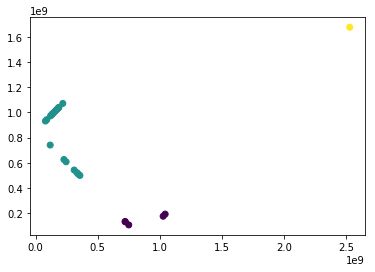

[[6.43000000e+01 7.48558695e+06 2.49846617e+08 6.50000000e-01
  3.50000000e-01]
 [1.92800000e+02 3.95286276e+07 1.10145709e+09 0.00000000e+00
  1.00000000e+00]
 [4.02000000e+02 6.16274310e+07 2.77815236e+09 0.00000000e+00
  1.00000000e+00]]


array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0])

In [33]:
## Run algorithm and plot output
## K of 3
####https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097
X = Classdf2.loc[:, 'Available Beds':'Short Term Acute Care']
# create kmeans object
kmeans = KMeans(n_clusters=3)
# # fit kmeans object to data
kmeans.fit(Classdf2)
# # print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(Classdf2)
# y_km
clust = kmeans.labels_
test = kmeans.fit_transform(X)
test
plt.scatter(test[:, 0], test[:, 1], c=clust)
plt.show()
print(kmeans.cluster_centers_)
y_km = kmeans.fit_predict(Classdf2)
y_km


In [34]:
###add KMeans classifcation to FinalRank DF
FinalRank2["KMeans"]=y_km
# FinalRank2

IPRankFin=pd.merge(IPRank,FinalRank2, how = 'left', on = ['HOSPITAL_NME'])
OPRankFin=pd.merge(OPRank,FinalRank2, how = 'left', on = ['HOSPITAL_NME'])
# IPRankFin.head()


###Export to CSV
# FinalRank2.to_csv("FinalRank4.csv", sep=",")
# IPRankFin.to_csv('IPRankKMeans2.csv', sep=',')
# OPRankFin.to_csv('OPRankKMeans2.csv', sep=',')
# %pwd
OPRank.head()

,Unnamed: 0,HOSPITAL_NME,HDD_HOSPITAL_CDE,DISCHARGE_TYPE,Avr Expense,Rank1,Avr Expense ED,Rank2,Percent_Males,Avg Age,...,Rank5,Medicaid,Rank6,Commercial,Avg_Billed_ICD9,Avg_Billed_ICD10,Rank7,Num Discharges,Num Instate,Num Males
0,0,Alice Peck Day Memorial Hospital,APD,OP,3226.46,23,1204.87,1,0.420642,44,...,25,1898.560648,17,3351.787882,3102.76,3598.24,24,9224,5157,3880
1,1,Androscoggin Valley Hospital,AVH,OP,1005.62,3,1958.20,10,0.424452,56,...,4,1248.660924,4,966.574903,1011.28,988.31,2,53893,52790,22875
2,2,Catholic Medical Center,CMC,OP,1848.49,14,3293.57,23,0.435091,59,...,13,2047.543083,18,2254.659097,1840.81,1871.87,14,220556,216961,95962
3,3,Cheshire Medical Center,CHE,OP,1475.80,11,2736.21,20,0.409542,63,...,3,2244.662621,22,2269.639546,1529.31,1649.46,12,140999,126282,57745
4,4,Concord Hospital,CON,OP,1616.01,13,2430.80,17,0.433605,57,...,10,2143.247029,20,2132.370138,1605.32,1649.84,13,305730,301413,132566


# Create Cluter Ranking Inpatient


In [46]:
### Separate Into Clusters for rankings  (Cluster 1 has only 1 hospital)
IPCluster0=IPRankInpute[IPRankInpute.KMeans==0]
IPCluster1=IPRankInpute[IPRankInpute.KMeans==1]
IPCluster2=IPRankInpute[IPRankInpute.KMeans==2]

In [49]:
## Create Rankings Cluster 0

IPCluster0["Rank1C"]=IPCluster0["Avr Expense"].rank(ascending=True)
IPCluster0["Rank2C"]=IPCluster0["Avr Expense ED"].rank(ascending=True)
IPCluster0["Rank3C"]=IPCluster0["DRG_EXPENSE1"].rank(ascending=True)
IPCluster0["Rank4C"]=IPCluster0["DRG_EXPENSE2"].rank(ascending=True)
IPCluster0["Rank5C"]=IPCluster0["Medicare"].rank(ascending=True)
IPCluster0["Rank6C"]=IPCluster0["Medicaid"].rank(ascending=True)
IPCluster0["Rank7C"]=IPCluster0["Avg_Billed_ICD10"].rank(ascending=True)
IPCluster0['Sum_RankC']=(IPCluster0['Rank1C']*2)+(IPCluster0['Rank2C']*2)+IPCluster0['Rank3C']+IPCluster0['Rank4C']+(IPCluster0['Rank5C']*1.5)+(IPCluster0['Rank6C']*1.5)+IPCluster0['Rank7C']
IPCluster0["Final_Rank_Cluster"]=IPCluster0["Sum_RankC"].rank(ascending=True)
IPCluster0


## Cluster 1 has only 1 hospital

###Create Ranks for cluster 2

IPCluster2["Rank1C"]=IPCluster2["Avr Expense"].rank(ascending=True)
IPCluster2["Rank2C"]=IPCluster2["Avr Expense ED"].rank(ascending=True)
IPCluster2["Rank3C"]=IPCluster2["DRG_EXPENSE1"].rank(ascending=True)
IPCluster2["Rank4C"]=IPCluster2["DRG_EXPENSE2"].rank(ascending=True)
IPCluster2["Rank5C"]=IPCluster2["Medicare"].rank(ascending=True)
IPCluster2["Rank6C"]=IPCluster2["Medicaid"].rank(ascending=True)
IPCluster2["Rank7C"]=IPCluster2["Avg_Billed_ICD10"].rank(ascending=True)
IPCluster2['Sum_RankC']=(IPCluster2['Rank1C']*2)+(IPCluster2['Rank2C']*2)+IPCluster2['Rank3C']+IPCluster2['Rank4C']+(IPCluster2['Rank5C']*1.5)+(IPCluster2['Rank6C']*1.5)+IPCluster2['Rank7C']
IPCluster2["Final_Rank_Cluster"]=IPCluster2["Sum_RankC"].rank(ascending=True)

###Concatenate DF
IPRankClusterFinal=pd.concat([IPCluster0, IPCluster2, IPCluster1], ignore_index=True)
IPRankClusterFinal.head()
# IPRankClusterFinal.shape
# IPRankClusterFinal.columns.values
# IPRankClusterFinal.to_csv("IPRankClusterFinal.csv")


,Available Beds,Avg Age,Avg_Billed_ICD10,Avg_Billed_ICD9,Avr Expense,Avr Expense ED,Avr LOS,Avr_Daily_Expense,Commercial,DISCHARGE_TYPE,DRG_EXPENSE1,DRG_EXPENSE2,DRG_EXPENSE3,DRG_EXPENSE4,DRG_EXPENSE5,Final_Rank,Final_Rank_Cluster,Gross Patient Revenue,HDD_HOSPITAL_CDE,HOSPITAL_NME,HospID,Inpatient Days,KMeans,Medicaid,Medicare,...,Rank2C,Rank3,Rank3C,Rank4,Rank4C,Rank5,Rank5C,Rank6,Rank6C,Rank7,Rank7C,Sum_Rank,Sum_RankC,TPS Quality Score:,Total Discharges:,Total Patient Days:,Total Patient Revenue:,Total Revenue,Total Staffed Beds:,Total_Revenue,Type of Control:,Type of Facility:,Unnamed: 0,Unnamed: 49,index
0,25,59,11723.49,10799.98,11051.53,12842.42,3.198,4473.062295,9295.00232,IP,80179.52,79185.00,43646.90,42504.80,38478.28,1.0,1.0,146860494,MCH,Monadnock Community Hospital,301309,4320,0,7177.232571,13108.31664,...,6.0,7,5.0,9,5.0,4,3.0,1,1.0,2,1.0,41.5,33.0,0.00,1144,4320,146860494,159820047,25,159820047,"Voluntary Nonprofit, Other",Critical Access,15,NaN,15
1,70,54,14370.82,13433.80,13671.53,27463.60,3.488,7736.772738,10700.58866,IP,718670.62,29504.71,85584.72,73091.02,70930.45,8.0,6.0,126172890,MEM,Memorial Hospital,301307,21566,0,8908.032574,16002.82927,...,15.0,26,20.0,1,1.0,7,6.0,2,2.0,5,4.0,97.5,77.0,0.00,1471,5525,126172890,130034982,70,130034982,"Voluntary Nonprofit, Other",Critical Access,14,NaN,14
2,35,58,12863.08,13837.99,18471.22,25476.44,7.090,4398.135665,13678.68252,IP,88726.77,69176.42,52918.32,44015.68,42769.33,4.5,3.0,61313202,COT,Cottage Hospital,301301,7338,0,10381.935000,13640.28087,...,14.0,8,6.0,6,4.0,5,4.0,4,3.0,4,3.0,91.5,69.5,0.00,541,4350,61313202,62234235,35,62234235,"Voluntary Nonprofit, Other",Critical Access,5,NaN,5
3,206,52,18493.08,18493.08,34281.64,10048.01,4.431,5040.178749,21914.49371,IP,98507.30,49877.45,54514.75,50224.82,46814.30,4.5,4.0,1266883497,CON,Concord Hospital,300001,61760,0,12960.262500,17412.11713,...,3.0,9,7.0,2,2.0,9,7.0,6,4.0,10,7.0,91.5,72.5,31.52,13141,57689,1266883497,1292411152,206,1292411152,"Voluntary Nonprofit, Other",Short Term Acute Care,4,NaN,4
4,258,70,21391.36,21628.73,42689.78,14259.44,4.877,2183.784376,18656.18403,IP,110376.00,59085.22,372782.93,233805.42,205004.61,14.0,10.0,1253669558,CMC,Catholic Medical Center,300034,66746,0,17639.245960,26274.31111,...,7.0,12,10.0,5,3.0,16,11.0,9,5.0,14,9.0,132.5,98.0,30.85,10831,61546,1253669558,1275654934,258,1275654934,"Voluntary Nonprofit, Other",Short Term Acute Care,2,NaN,2


# Create Cluter Ranking Outpatient

In [50]:
### Separate Outpatient Clusters for rankings
OPCluster0=OPRankFin[OPRankFin.KMeans==0]
OPCluster2=OPRankFin[OPRankFin.KMeans==2]
OPCluster1=OPRankFin[OPRankFin.KMeans==1]

In [51]:
##OP CLuster 0

OPCluster0["Rank1C"]=OPCluster0["Avr Expense"].rank(ascending=True)
OPCluster0["Rank2C"]=OPCluster0["Avr Expense ED"].rank(ascending=True)
OPCluster0["Rank5C"]=OPCluster0["Medicare"].rank(ascending=True)
OPCluster0["Rank6C"]=OPCluster0["Medicaid"].rank(ascending=True)
OPCluster0["Rank7C"]=OPCluster0["Avg_Billed_ICD10"].rank(ascending=True)
OPCluster0['Sum_RankC']=(OPCluster0['Rank1C']*2)+(OPCluster0['Rank2C']*2)+(OPCluster0['Rank5C']*1.5)+(OPCluster0['Rank6C']*1.5)+OPCluster0['Rank7C']
OPCluster0["Final_Rank_Cluster"]=OPCluster0["Sum_RankC"].rank(ascending=True)
# OPCluster0

#Rankings OP Cluster 2
OPCluster2["Rank1C"]=OPCluster2["Avr Expense"].rank(ascending=True)
OPCluster2["Rank2C"]=OPCluster2["Avr Expense ED"].rank(ascending=True)
OPCluster2["Rank5C"]=OPCluster2["Medicare"].rank(ascending=True)
OPCluster2["Rank6C"]=OPCluster2["Medicaid"].rank(ascending=True)
OPCluster2["Rank7C"]=OPCluster2["Avg_Billed_ICD10"].rank(ascending=True)
OPCluster2['Sum_RankC']=(OPCluster2['Rank1C']*2)+(OPCluster2['Rank2C']*2)+(OPCluster2['Rank5C']*1.5)+(OPCluster2['Rank6C']*1.5)+OPCluster2['Rank7C']
OPCluster2["Final_Rank_Cluster"]=OPCluster2["Sum_RankC"].rank(ascending=True)
# OPCluster2

##Concatenate OP and Files:
OPRankClusterFinal=pd.concat([OPCluster0, OPCluster2, OPCluster1], ignore_index=True)
OPRankClusterFinal.head()
# OPRankClusterFinal.shape
# IPRankClusterFinal.columns.values
# OPRankClusterFinal.to_csv("OPRankClusterFinal.csv")


,Available Beds,Avg Age,Avg_Billed_ICD10,Avg_Billed_ICD9,Avr Expense,Avr Expense ED,Commercial,DISCHARGE_TYPE,Final_Rank,Final_Rank_Cluster,Gross Patient Revenue,HDD_HOSPITAL_CDE,HOSPITAL_NME,HospID,Inpatient Days,KMeans,Medicaid,Medicare,Most_Freq_Payer,Net Income (or Loss),Non-Patient Revenue,Num Discharges,Num Instate,Num Males,Percent_In_State,Percent_Males,Rank1,Rank1C,Rank2,Rank2C,Rank5,Rank5C,Rank6,Rank6C,Rank7,Rank7C,Sum_Rank,Sum_RankC,TPS Quality Score:,Total Discharges:,Total Patient Days:,Total Patient Revenue:,Total Revenue,Total Staffed Beds:,Total_Revenue,Type of Control:,Type of Facility:,Unnamed: 0
0,24.0,44,3598.24,3102.76,3226.46,1204.87,3351.787882,OP,19.0,15.0,100344066.0,APD,Alice Peck Day Memorial Hospital,301305,5347.0,0,1898.560648,4551.034937,Commercial,459864.0,1784232.0,9224,5157,3880,0.559085,0.420642,23,18.0,1,1.0,25,19.0,17,16.0,24,18.0,135.0,108.5,0.00,1104.0,5349.0,100344066.0,102128298.00,24.0,102128298.0,"Voluntary Nonprofit, Other",Critical Access,0
1,25.0,56,988.31,1011.28,1005.62,1958.20,966.574903,OP,2.0,3.0,88754663.0,AVH,Androscoggin Valley Hospital,301310,4815.0,0,1248.660924,1030.645817,Medicare,4461667.0,4740964.0,53893,52790,22875,0.979534,0.424452,3,3.0,10,10.0,4,4.0,4,4.0,2,2.0,40.0,40.0,0.00,959.0,4815.0,88754663.0,93495627.00,25.0,93495627.0,"Voluntary Nonprofit, Other",Critical Access,1
2,113.0,63,1649.46,1529.31,1475.80,2736.21,2269.639546,OP,15.0,14.0,577837958.0,CHE,Cheshire Medical Center,300019,19955.0,0,2244.662621,1029.259762,Medicare,-3217847.0,3981213.0,140999,126282,57745,0.895623,0.409542,11,10.0,20,18.0,3,3.0,22,19.0,12,11.0,111.5,100.0,46.58,3874.0,16092.0,577837958.0,581819171.00,113.0,581819171.0,"Voluntary Nonprofit, Other",Short Term Acute Care,3
3,35.0,47,2209.39,2124.82,2144.04,1834.12,2063.582248,OP,12.0,12.0,61313202.0,COT,Cottage Hospital,301301,7338.0,0,1473.448673,2866.749921,Commercial,20713.0,921033.0,8254,4177,3859,0.506058,0.467531,15,12.0,7,7.0,17,13.0,6,6.0,15,12.0,93.5,78.5,0.00,541.0,4350.0,61313202.0,62234235.00,35.0,62234235.0,"Voluntary Nonprofit, Other",Critical Access,5
4,97.0,53,2719.26,2529.39,2577.62,1999.93,2432.272859,OP,17.0,16.0,565533819.0,EXE,Exeter Hospital,300023,22293.0,0,1849.208929,2914.736636,Commercial,40375077.0,25681232.0,124188,119091,48596,0.958957,0.391310,19,15.0,12,12.0,18,14.0,14,13.0,21,16.0,131.0,110.5,39.70,5336.0,22293.0,565533819.0,591215051.00,97.0,591215051.0,"Voluntary Nonprofit, Other",Short Term Acute Care,8
